In [2]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import warnings
import random as rn
warnings.filterwarnings("ignore")

In [3]:
# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


In [4]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [5]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [6]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [7]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [8]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [9]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [10]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [11]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [12]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [13]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [14]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [15]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [16]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [17]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [18]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [19]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

In [28]:

common_cells_across_methods = pd.read_csv("../../../../results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/compare_annotation_performances/commonCells.csv", index_col=False)

In [29]:
common_cells_across_methods

,0
0,CMP_177
1,CMP_639
2,GMP_264
3,GMP_131
4,HSC_210
...,...
1866,MEP_17
1867,MPP_173
1868,CMP_7
1869,MPP_82


In [30]:
leiden_resolutions = ['0.1' ,'0.2' ,'0.3' ,'0.4' ,'0.5' ,'0.6' ,'0.7' ,'0.8' ,'0.9' ,'1.0' ,'1.1' ,'1.2' ,'1.3' ,'1.4' ,'1.5' ,'1.6' ,'1.7','1.8' ,'1.9' ,'2.0', '2.1', '2.2', '2.3', '2.4', '2.5']

In [31]:
# prepare results dataframe

scores_df = pd.DataFrame( index=['leiden_'+i for i in leiden_resolutions])

In [38]:
for res in leiden_resolutions:
    result_path = "../../../../results/Supplementary_tables/analysis_on_clustering_parameter/FACS_BM_scATAC_performance_acros_clustering_res/res"+ res + "/outputs/scATAcat_annotations_leiden_" + res +".csv"
    scATAcat_annotations = pd.read_csv(result_path, index_col=0)
    scATAcat_annotations.columns = ['leiden_'+res, 'scATAcat_annotation' ,'ground_truth_annotations']
    scATAcat_annotations['cell_IDs'] = scATAcat_annotations.index
    cluster_id_column ='leiden_'+res
    scATAcat_annotations.index.name = None
    common_cells = list(common_cells_across_methods['0'])
    all_methods_for_commonCells= get_combined_annotations_df_for_common_cells(scATAcat_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")
    common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation))
    all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations.isin(common_annotations)]
    annotation_df = all_methods_for_commonCells_commonAnnotations
    correct_id_col = 'ground_truth_annotations'
    predicted_id_col = "scATAcat_annotation"
    scores_df.loc['leiden_'+ res, "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
    scores_df.loc['leiden_'+ res, "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, 'num_clust'] = scATAcat_annotations['leiden_'+ res].max()+1


In [45]:
scores_df.iloc[:,:-1]

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
leiden_0.1,0.950345,0.956546,1.000000,0.950882,0.955048,0.948301,0.963854,0.932818,0.869046,0.932257
leiden_0.2,0.902743,0.932123,1.000000,0.914373,0.907317,0.906977,0.941176,0.870241,0.738657,0.868593
leiden_0.3,0.899626,0.933274,1.000000,0.912441,0.907317,0.906977,0.977941,0.868806,0.730075,0.864970
leiden_0.4,0.884570,0.908008,1.000000,0.884253,0.890954,0.872498,0.923941,0.851019,0.724319,0.849336
leiden_0.5,0.881037,0.906307,1.000000,0.881887,0.886056,0.869444,0.922716,0.846667,0.715130,0.844821
leiden_0.6,0.881625,0.906716,1.000000,0.882221,0.887060,0.869602,0.923941,0.847498,0.716727,0.845606
leiden_0.7,0.882214,0.906974,1.000000,0.882007,0.888577,0.871529,0.923941,0.848216,0.718926,0.846378
leiden_0.8,0.881037,0.906457,1.000000,0.881346,0.886595,0.869602,0.923941,0.846800,0.715681,0.844875
leiden_0.9,0.741453,0.755912,0.900000,0.724031,0.805687,0.812227,0.904255,0.686618,0.548008,0.679256
leiden_1.0,0.741453,0.756512,0.900000,0.725332,0.805687,0.812227,0.904255,0.686632,0.551256,0.679468


In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Adjust the color list to ensure the last colors are not too light
# Removed the lightest color and adjusted the gradient to end with a color that's clearly visible
# colors = ["#00429d", "#4771b2", "#73a2c6", "#a5d5d8", "#cae1e9", "#e8fc03"]  # Dark to less light
# colors = ['#004E72', '#004CB6', '#004E72', '#007CB6','#007CB6']
n_bins = 25  # Adjusted for 25 bars
#colors = ['#122640', '#122640']
# # Create the colormap
#custom_colormap = LinearSegmentedColormap.from_list("custom_sequential", colors, N=n_bins)

#custom_colormap = LinearSegmentedColormap.from_list("custom_sequential", ['#00429d', "#cae1e9"])

custom_colormap = LinearSegmentedColormap.from_list("custom_sequential", ['#00429d', "#C3E1FF"])
#custom_colormap = LinearSegmentedColormap.from_list("custom_sequential", ['#3E606F', "#D1DBBD"])

custom_colormap = LinearSegmentedColormap.from_list("custom_sequential", ['#07748C', "#C9E2F2"])


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'accuracy'),
  Text(1, 0, 'balanced_accuracy'),
  Text(2, 0, 'cluster_accuracy'),
  Text(3, 0, 'macroF1_score'),
  Text(4, 0, 'medianF1_score'),
  Text(5, 0, 'medianPrecision_score'),
  Text(6, 0, 'medianRecall_score'),
  Text(7, 0, 'mathews_corr_coef_score'),
  Text(8, 0, 'adjusted_rand_score'),
  Text(9, 0, 'cohens_kappa_score')])

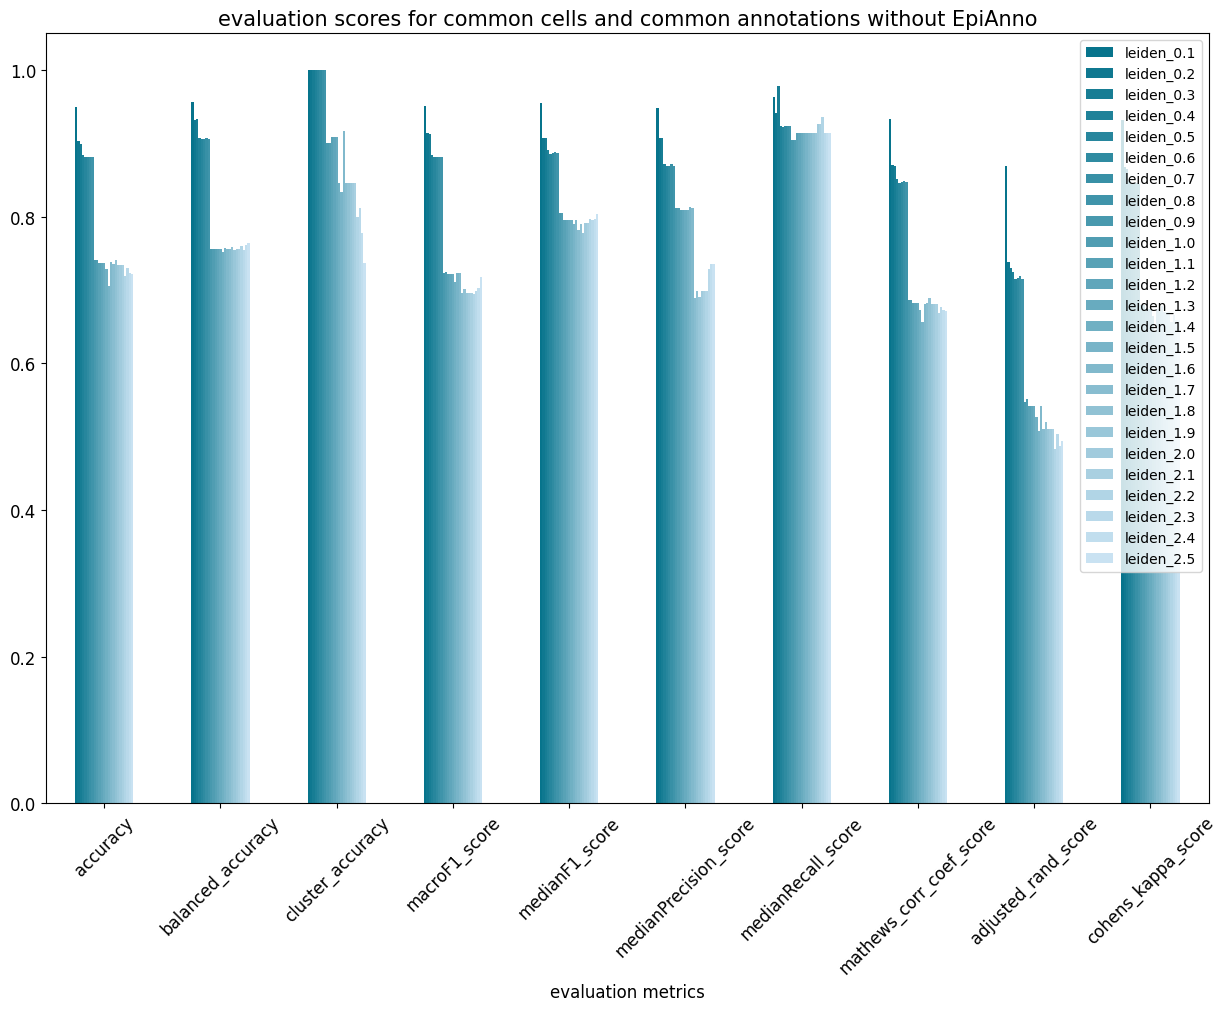

In [99]:
import matplotlib.pyplot as plt

ax = scores_df.iloc[:,:-1].T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12, colormap=custom_colormap)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for common cells and common annotations without EpiAnno", fontsize=15)
plt.xticks(rotation=45)

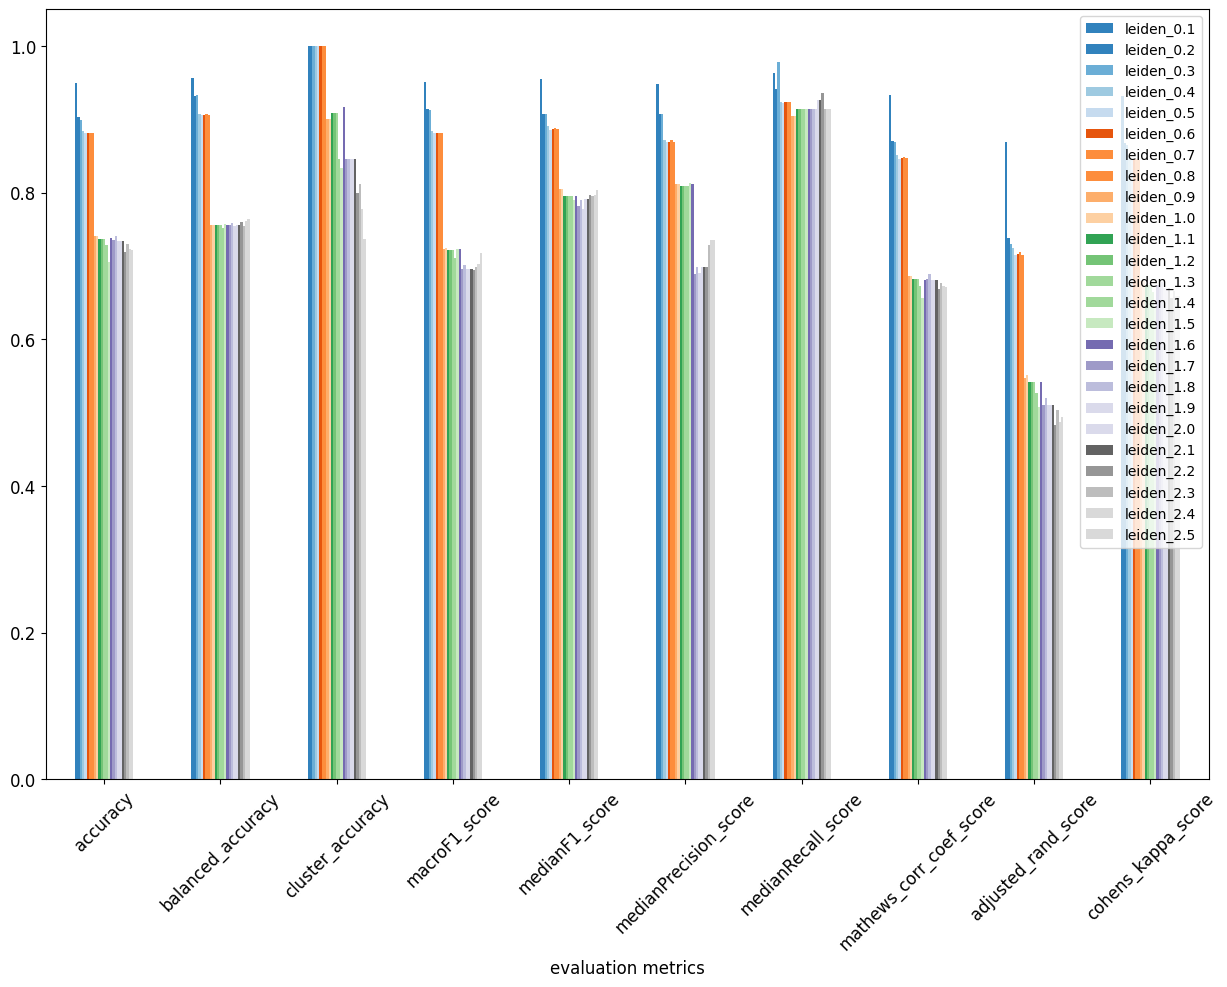

In [107]:
import matplotlib.pyplot as plt

ax = scores_df.iloc[:,:-1].T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12,colormap='tab20c')
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
#plt.title("evaluation scores for common cells and common annotations without EpiAnno", fontsize=15)
plt.xticks(rotation=45)
plt.show()

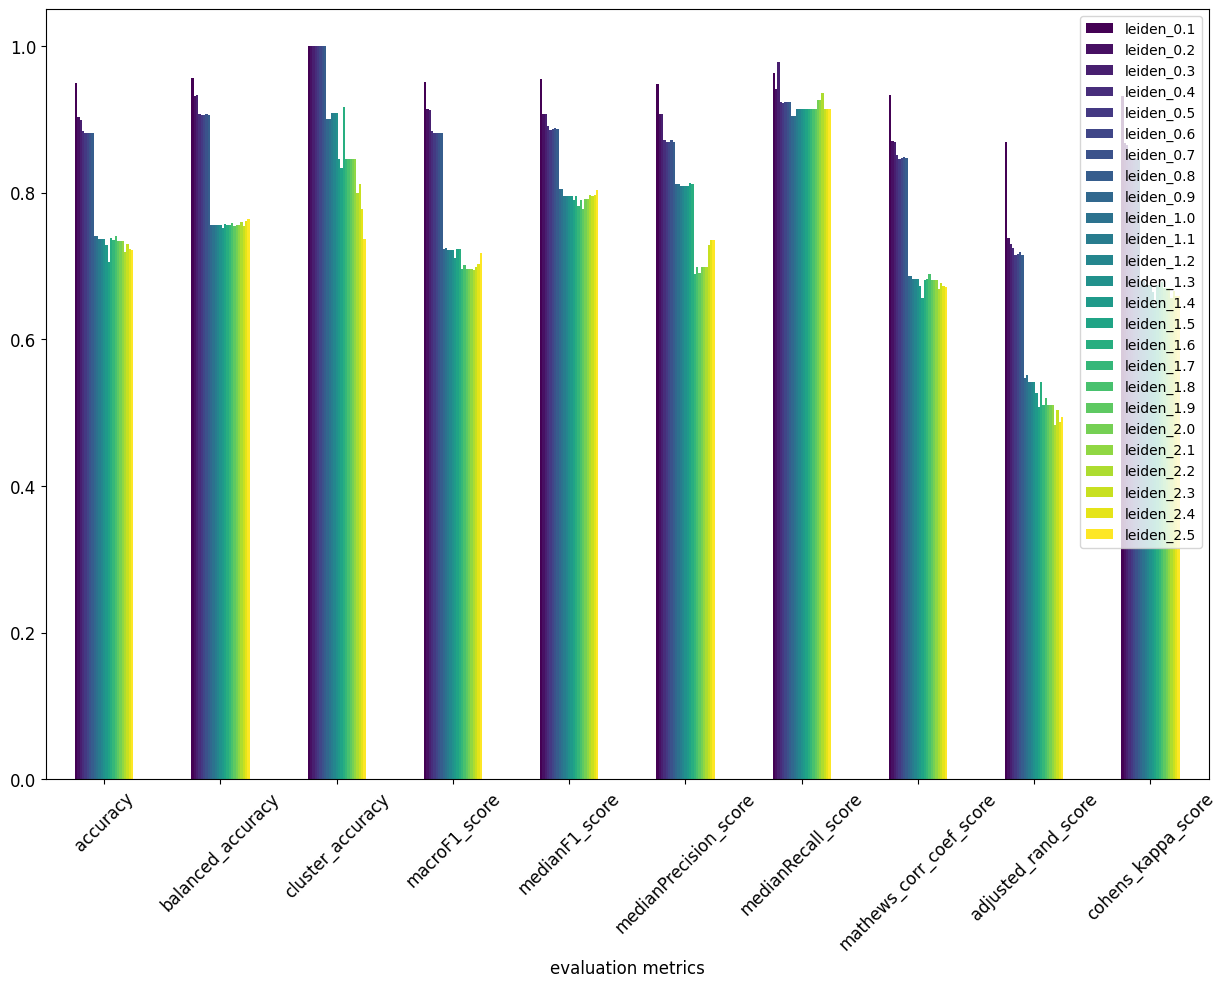

In [110]:
import matplotlib.pyplot as plt

ax = scores_df.iloc[:,:-1].T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12,colormap='viridis')
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
#plt.title("evaluation scores for common cells and common annotations without EpiAnno", fontsize=15)
plt.xticks(rotation=45)
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'accuracy'),
  Text(1, 0, 'balanced_accuracy'),
  Text(2, 0, 'cluster_accuracy'),
  Text(3, 0, 'macroF1_score'),
  Text(4, 0, 'medianF1_score'),
  Text(5, 0, 'medianPrecision_score'),
  Text(6, 0, 'medianRecall_score'),
  Text(7, 0, 'mathews_corr_coef_score'),
  Text(8, 0, 'adjusted_rand_score'),
  Text(9, 0, 'cohens_kappa_score')])

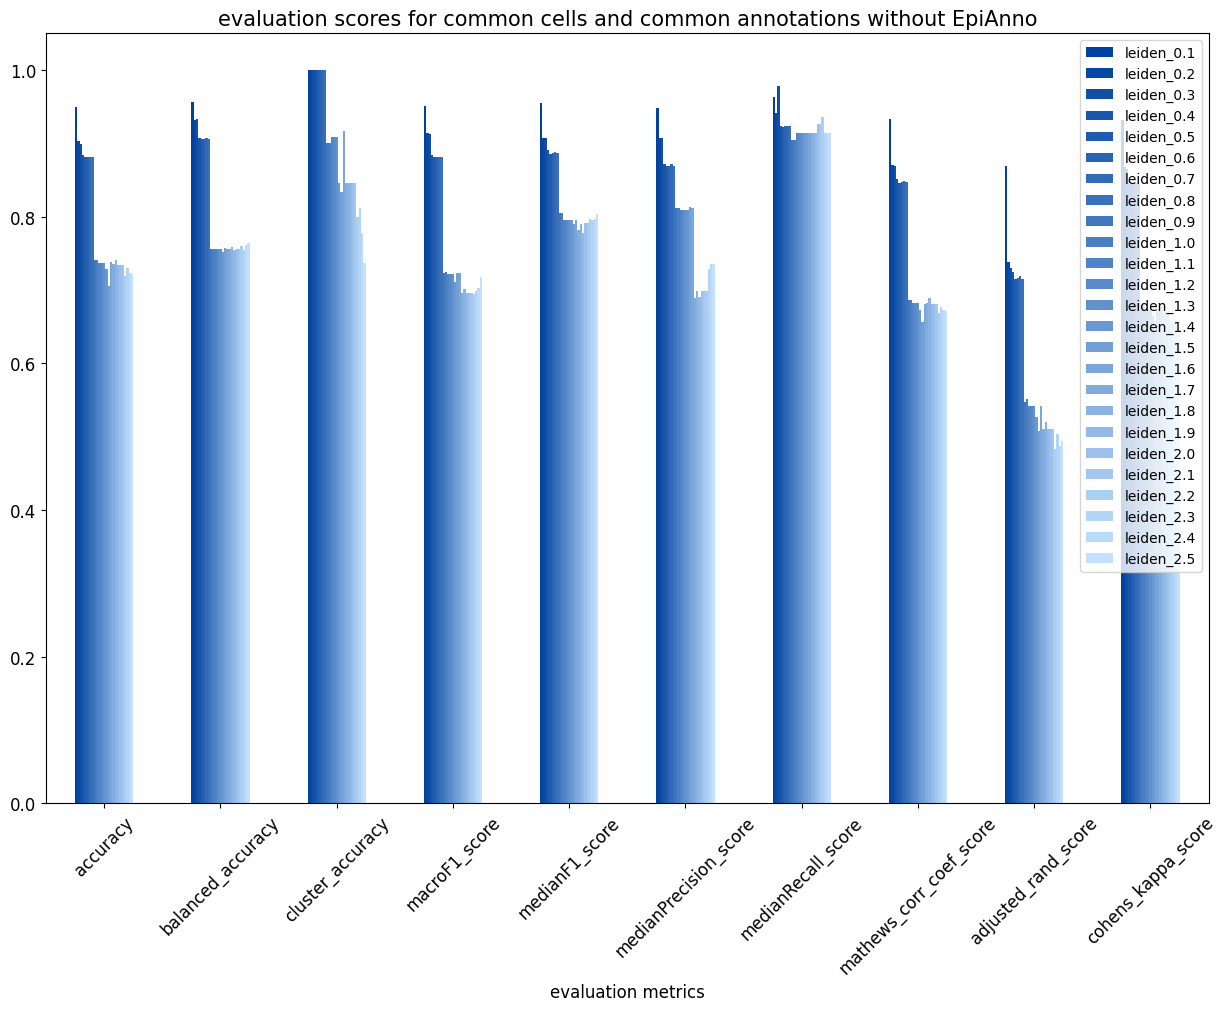

In [97]:
import matplotlib.pyplot as plt

ax = scores_df.iloc[:,:-1].T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12, colormap=custom_colormap)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for common cells and common annotations without EpiAnno", fontsize=15)
plt.xticks(rotation=45)

In [17]:
acc_comparisons.to_csv('../../../results/Supplementary_tables/ST3-FACS_BM_scATAC_accuracy_acros_clustering_res/ST3-FACS_BM_scATAC_accuracy_acros_clustering_res.csv')